### Methods for boundary value problems

Main references

[^1]: Timothy Sauer (2017) *Numerical Analysis* 3rd Edition. (p. 348)

#### Take-aways

After studying this chapter, we will be able to

TBF



#### Overview



##### Problem of interest

> **Problem of interest** (Two points boundary value problem)
>
> Given $f:\mathbb{R}^{3} \to \mathbb{R}$, find $y:[a,b]\to \mathbb{R}$ that satisfies
>     
> $$
> \begin{cases}
> y'' = f(t, y, y') \\
> y(a) = y_a \\
> y(b) = y_b.
> \end{cases}
> $$


**Remark** (Problem first, then methods)

- Unlike other undergradute mathematics classes, we study numerical methods for certain problems of interest. Thus, it is important to focus on the problem, and then think about possible methods.
- You will see methods bearing the same name multiple times for different problems of interest. Even though they have the same name (because of the same idea behind it), the way they are used and analyzsed can be quite different. That is because the nature of the problems are completely different and the numerical methods somehow *embody* the problem at the discrete level.

#### Shooting method

##### Method outline

1. Construct an associated zero finding problem $F(s^*)=0$, whose evaluation corresponds to an IVP.
   1. Pose an IVP: Choose one boundary condition (typically the left boundary point $y_a$) and supplement it with a guess initial velocity $y'(a)=s$.
   2. Input of $F$ is the guess initial velocity $s$. 
   3. Output of $F$ is the final position $y_N$ of the numerical solution to the IVP. (An IVP solver is implemented. And the dimension is increased to $\mathbb{R}^2$ by augmenting the velocity component.)
2. Solve the zero finding problem.
3. Find the solution to the BVP by computing the trajectory of the IVP associated with the found zero.

In [ ]:
"""Secant method sanity check"""
import internallib

f = lambda x: x*x - 2
root, iteration = internallib.secant(f, 5, 10)
print(f"Root: {root}  ({iteration} iterations taken)")  
print(f"True: {2**(1/2)}")

In [ ]:
"""RK4 sanity check"""
import numpy as np
import matplotlib.pyplot as plt

# change the overal font size 
plt.rcParams.update({"font.size": 16})

# helix equation
omega = 1.
kappa = 1.
G = lambda t, x: np.array([-omega*x[1], omega*x[0], kappa])

sol, tgrid = internallib.RK4(G, np.array([1., 0., 0.]), 0, 20, 100)

# create subplots for 3d plots
fig, ax = plt.subplots(subplot_kw={'projection': "3d"})

# plot a curve
ax.plot(*sol.T)

plt.show()

**Example** (Implementing shooting method)

Apply the Shooting Method to the boundary value problem
$$
\left\{\begin{array}{l}
y^{\prime \prime}=4 y \\
y(0)=1 \\
y(1)=3
\end{array}\right.
$$


$$
\begin{align}
u = y'\\
u' = y'' = 4y
\end{align}
$$

$$
\begin{bmatrix}
y \\ 
u 
\end{bmatrix} ' 
= F\left( 
\begin{bmatrix}
y \\ 
u 
\end{bmatrix} 
\right)
=
\begin{bmatrix}
u \\ 
4y
\end{bmatrix}
$$

The true solution can be obtained by the standard method of second order differential equations.

$$y(t)=\frac{3-e^{-2}}{e^2-e^{-2}} e^{2 t}+\frac{e^2-3}{e^2-e^{-2}} e^{-2 t}$$

In [ ]:
"""Implementing the shooting method"""

import internallib
import numpy as np

# function that converts the problem into a root finding problem
def F_(s, bc1, bc2, slope, a, b, N):

    x0 = np.array([bc1, s])

    sol, tgrid = internallib.RK4(slope, x0, a, b, N)

    return sol[-1, 0] - bc2

# problem and numerical settings
N = 100
a, rhs = 0., 1.
slope = lambda t, x: np.array([x[1], 4.*x[0]])
bc1 = 1.
bc2 = 3.

# simplified function for root finding
F = lambda s: F_(s, bc1=bc1, bc2=bc2, slope=slope, a=a, b=rhs, N=N)

print(F(-1.))


In [ ]:
# solve the main root finding problem
secant_guess1 = -1.
secant_guess2 = 0.
s_s, iter = internallib.secant(F, secant_guess1, secant_guess2)

print(s_s, iter)

# compute the trajectory
sol, tgrid =internallib.RK4(slope, np.array([bc1, s_s]), a, rhs, N)


In [ ]:

# exact solution
em2 = np.exp(-2.)
e2 = np.exp(2.)
c1 = (3. - em2) / (e2 - em2)
c2 = (e2 - 3.) / (e2 - em2)

true_sol_lamb = lambda t: c1*np.exp(2.*t) + c2*np.exp(-2.*t)

true_sol = true_sol_lamb(tgrid)

In [ ]:
import matplotlib.pyplot as plt

# change the overal font size 
plt.rcParams.update({"font.size": 16})

# create subplots for 3d plots
fig, ax = plt.subplots()

# plot the numerical and true solution
ax.plot(tgrid, sol.T[0])
ax.plot(tgrid, true_sol)
plt.legend(["Numerical", "True"])
plt.show()


#### Finite Difference Method (FDM) for Two Pt BVP


**Idea**: confine the domain to a set of grid points, and replace differential operators with their discrete counterparts of finite difference form.


###### Difference Quotient

**Centered Difference Quotient for 1st order derivative**

$$
y^{\prime}(t)=\frac{y(t+h)-y(t-h)}{2 h}-\frac{h^2}{6} y^{\prime \prime \prime}(c)
$$

**Centered Difference Quotient for 2nd order derivative**

$$
y^{\prime \prime}(t)=\frac{y(t+h)-2 y(t)+y(t-h)}{h^2}+\frac{h^2}{12} f^{\prime \prime \prime \prime}(c) .
$$

This approximation is intuitively sensible:

$$
\begin{split}
f'(x+h) &\approx \frac{f(x+h)-f(x)}{h}\\
f'(x) &\approx \frac{f(x)-f(x-h)}{h}\\
f''(x) &\approx \frac{f'(x+h)-f'(x)}{h}\\
&\approx \frac{\frac{f(x+h)-f(x)}{h}-\frac{f(x)-f(x-h)}{h}}{h}\\
&\approx \frac{f(x+h)-2f(x)+f(x-h)}{h^2}
\end{split}
$$

###### Grid domain

![Grid domain for two point BVP](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Finite_Differences.svg/429px-Finite_Differences.svg.png?20110221193510)

The figure uses different symbols from us. Substitute:

- $x\gets t$

Figure: Wikipedia (uniform grid domain)

##### Settings/Notation

| symbol | meaning |
|---|---|
| $n$ | grid resolution | 
| $h$ | $=\frac{b-a}{n+1}$ grid spacing |
| $t_i$ | $=a+hi$ ($i=0,1,\cdots,n+1$) $i$-th grid point |
| $y(t_i)$ | true solution evaluated at $(t_i)$ |
| $w_{i}$ | numerical solution meant to approximate $y(t_i)$ |


**Example** (Implementing FDM)

Apply the FDM to the boundary value problem
$$
\left\{\begin{array}{l}
y^{\prime \prime}=4 y \\
y(0)=1 \\
y(1)=3
\end{array}\right.
$$


- Replace derivatives with difference quotient

$$
\frac{w_{i+1}-2 w_i+w_{i-1}}{h^2}-4 w_i=0
$$

- Rearrange

$$
w_{i-1}+\left(-4 h^2-2\right) w_i+w_{i+1}=0, \quad (i=1,2,\cdots,n)
$$



- Matrix form 

Plug $i=1,2,\cdots, n$ in the above equation and rewrite the resulting equations.

$$
\left[\begin{array}{ccccccc}
-4 h^2-2 & 1 & 0 & \cdots & 0 & 0 & 0 \\
1 & -4 h^2-2 & \ddots & & 0 & 0 & 0 \\
0 & 1 & \ddots & \ddots & 0 & 0 & 0 \\
\vdots & & \ddots & \ddots & \ddots & & \vdots \\
0 & 0 & 0 & \ddots & \ddots & 1 & 0 \\
0 & 0 & 0 & & \ddots & -4 h^2-2 & 1 \\
0 & 0 & 0 & \cdots & 0 & 1 & -4 h^2-2
\end{array}\right]\left[\begin{array}{c}
w_1 \\
w_2 \\
w_3 \\
\vdots \\
w_{n-1} \\
w_n
\end{array}\right]=\left[\begin{array}{r}
-1 \\
0 \\
0 \\
\vdots \\
0 \\
0 \\
-3
\end{array}\right] .
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from internallib import tridiag 

# rhs/acceleration function
f = lambda t, y: 4. * y

# Define the boundary conditions
a = 0
b = 1
ya = 1
yb = 3

# grid resolution/spacing
n = 100
h = (b - a) / (n + 1)

# grid domain
t = np.linspace(a, b, n+2)

# Initialize the solution array
w = np.zeros(n+2)

# Apply the boundary conditions
w[0] = ya
w[-1] = yb

diag = -4.*h*h - 2.
off_diag = 1.

# create the tridiagonal matrix (internal library)
# syntax: tridiag(sub_diag, diag, super_diag, size)
A = tridiag(off_diag, diag, off_diag, n)

rhs = np.zeros(n)
rhs[0] = -ya
rhs[-1] = -yb

In [2]:
# Solve the finite difference equations

w[1:-1] = np.linalg.solve(A, rhs)


In [3]:

# exact solution
em2 = np.exp(-2.)
e2 = np.exp(2.)
c1 = (3. - em2) / (e2 - em2)
c2 = (e2 - 3.) / (e2 - em2)

true_sol_lamb = lambda t: c1*np.exp(2.*t) + c2*np.exp(-2.*t)

true_sol = true_sol_lamb(t)

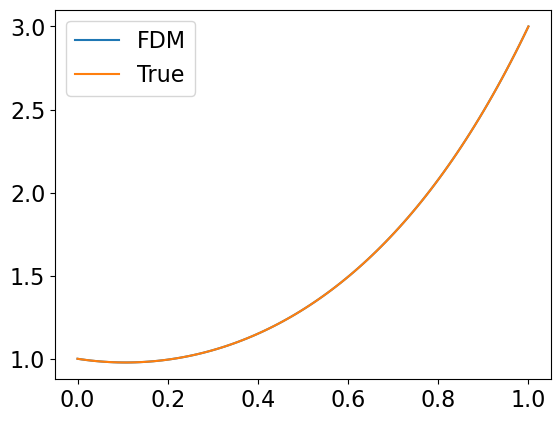

In [4]:
import matplotlib.pyplot as plt

# change the overal font size 
plt.rcParams.update({"font.size": 16})

# create subplots for 3d plots
fig, ax = plt.subplots()

# plot the numerical and true solution
ax.plot(t, w, label="FDM")
ax.plot(t, true_sol, label="True") 
plt.legend()
plt.show()


##### Nonlinear problems



All steps are the same as above, but one needs to nonlinear root-finding methods (Newton's or Broyden's methods) to compute the solution.

---
This work is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)